In [1]:
!pip install wandb -q
!pip install catboost -q
!pip install xgboost -q

In [2]:
!pip install phik -q

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
import catboost
from catboost import CatBoostClassifier, Pool, cv
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score
from sklearn.decomposition import PCA
# import optuna
import numpy as np

import random
import os
import torch

import wandb

Отобранные фичи, около 70 штук

In [2]:
selected_features_names= ['feature1',
  'feature3',
  'feature37',
  'feature43',
  'feature55',
  'feature152',
  'feature154',
  'feature162',
  'feature170',
  'feature178',
  'feature188',
  'feature190',
  'feature191',
  'feature198',
  'feature208',
  'feature209',
  'feature318',
  'feature319',
  'feature341',
  'feature349',
  'feature350',
  'feature356',
  'feature357',
  'feature405',
  'feature422',
  'feature435',
  'feature450',
  'feature461',
  'feature472',
  'feature499',
  'feature546',
  'feature548',
  'feature559',
  'feature713',
  'feature714',
  'feature758',
  'feature861',
  'feature862',
  'feature865',
  'feature869',
  'feature898',
  'feature900',
  'feature909',
  'feature913',
  'feature915',
  'feature920',
  'feature930',
  'feature935',
  'feature936',
  'feature937',
  'feature939',
  'feature940',
  'feature941',
  'feature944',
  'feature947',
  'feature949',
  'feature950',
  'feature951',
  'feature952',
  'feature953',
  'feature954',
  'feature988',
  'feature990',
  'feature992',
  'feature993',
  'feature994',
  'feature1000',
  'feature1002',
  'feature1003',
  'feature1004']

In [3]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

os.environ['PYTHONHASHSEED'] = str(SEED)

def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed()

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_parquet('/content/drive/MyDrive/Копия train_ai_comp_final_dp.parquet')[selected_features_names + ['target']]
df

,feature1,feature3,feature37,feature43,feature55,feature152,feature154,feature162,feature170,feature178,...,feature988,feature990,feature992,feature993,feature994,feature1000,feature1002,feature1003,feature1004,target
0,1761,85,85495,19131,27157,5099,383300,116910,162919,446934,...,0,1,5,8,16,1,3,6,14,0
1,1761,120,85495,59900,138924,49546,561368,66335,162919,456123,...,0,0,4,10,22,0,3,9,22,0
2,890,141,85495,11110,278364,2046,97389,19218,162919,211763,...,2,3,9,24,40,3,8,23,40,0
5,1599,30,85495,38606,148572,259281,18197,112356,162919,306530,...,1,2,5,5,5,2,3,3,3,0
6,1761,85,0,17927,438447,6750,429713,78336,162919,222166,...,0,1,6,12,14,1,4,10,12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
693036,1761,141,85495,59900,173987,259281,42517,33886,162919,21914,...,3,6,15,17,17,6,13,15,15,0
693038,1761,0,85495,59900,3990,259281,622982,29693,162919,7336,...,3,3,6,6,6,3,4,4,4,0
693039,1761,0,85495,59900,3047,259281,622982,29693,162919,7336,...,3,3,6,6,6,3,4,4,4,0
693040,1761,141,85495,59900,96411,259281,113943,888,162919,53742,...,0,0,2,2,2,0,0,0,0,0


In [14]:
import phik
corr_matrix = df[selected_features_names].phik_matrix().abs()
threshold = 0.8

# Находим пары признаков, которые сильно коррелируют
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

# Удаляем один из признаков из каждой пары сильно коррелирующих признаков
df.drop(df[to_drop], axis=1, inplace=True)


interval columns not set, guessing: ['feature1', 'feature3', 'feature37', 'feature43', 'feature55', 'feature152', 'feature154', 'feature162', 'feature170', 'feature178', 'feature188', 'feature190', 'feature191', 'feature198', 'feature208', 'feature209', 'feature318', 'feature319', 'feature341', 'feature349', 'feature350', 'feature356', 'feature357', 'feature405', 'feature422', 'feature435', 'feature450', 'feature461', 'feature472', 'feature499', 'feature546', 'feature548', 'feature559', 'feature713', 'feature714', 'feature758', 'feature861', 'feature862', 'feature865', 'feature869', 'feature898', 'feature900', 'feature909', 'feature913', 'feature915', 'feature920', 'feature930', 'feature935', 'feature936', 'feature937', 'feature939', 'feature940', 'feature941', 'feature944', 'feature947', 'feature949', 'feature950', 'feature951', 'feature952', 'feature953', 'feature954', 'feature988', 'feature990', 'feature992', 'feature993', 'feature994', 'feature1000', 'feature1002', 'feature1003', '

In [6]:
l = []
for col in selected_features_names:
    if len(df[col].unique()) == 1 and col != 'target':
        l.append(col)
cols_with_one_unique_num = l

In [7]:
def preproc(df):

    df = df.drop(cols_with_one_unique_num, axis=1)
    X_train, X_test, y_train, y_test = train_test_split(
    df.drop('target', axis=1),
    df['target'],
    test_size=0.2,
    random_state=42,
        shuffle=True,
        stratify=df['target']
    )

    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = preproc(df)

прочитаем сохраненные анномальные сэмплы, которые мы обнаружили с помощью автоенкодера



In [20]:
annomal = pd.read_csv('/content/ann.csv')

In [10]:
binary_ftrs = []
for col in df.columns:
    if len(df[col].unique()) == 2 and set(df[col].unique()) == set([0, 1]):
        binary_ftrs.append(col)
binary_ftrs.remove('target')

In [11]:
iters=5000
depth=10
grow_policy='Lossguide'
min_data_in_leaf=100
loss='Logloss'

In [ ]:
cb1 = CatBoostClassifier(
         iterations=1000,
         depth=10,
         loss_function='CrossEntropy',
         grow_policy='Lossguide',
         min_data_in_leaf=100,
         task_type= 'GPU',
         devices= 'cuda',
         verbose=250,
         random_state=42,
         l2_leaf_reg = 7
     )

cb2 = CatBoostClassifier(
         iterations=1000,
         depth=10,
         loss_function='CrossEntropy',
         grow_policy='Lossguide',
         min_data_in_leaf=10,
         task_type= 'GPU',
         devices= 'cuda',
         verbose=250,
         random_state=42,
         l2_leaf_reg = 10
     )

cb3 = CatBoostClassifier(
         iterations=1000,
         depth=7,
         loss_function='CrossEntropy',
         grow_policy='Lossguide',
         min_data_in_leaf=100,
         task_type= 'GPU',
         devices= 'cuda',
         verbose=250,
         random_state=42,
         l2_leaf_reg = 0.5
     )

In [ ]:
def cb_train(model, X, y):
    weight2zero = 7
    weights = [weight2zero if label == 1 else 1 for label in y]
    pool = Pool(X, label=y,
                weight=weights)
    model.fit(pool)

Фичи, полученные в результате арифметических операций над ними. 
Каждая из них дает какой-то импакт, отобрали лишь лучшие

In [ ]:
X_train['gold'] = X_train['feature546'] ** 3
X_train['gold2'] = (X_train['feature191'] + X_train['feature341']) / 2
#X_train['gold3'] = (X_train['feature162'] + X_train['feature862']) / 2
#X_train['gold4'] = X_train['feature992'] ** 3
#X_train['gold5'] = X_train['feature356'] ** 2
#X_train['gold6'] = (X_train['feature178'] + X_train['feature950']) / 2
#X_train['gold7'] = (X_train['feature190'] + X_train['feature949']) / 2
#X_train['gold8'] = (X_train['feature55'] + X_train['feature954']) / 2

In [ ]:
cb_train(cb1, X_train, y_train) ### weights
cb_train(cb2, X_train, y_train)
cb_train(cb3, X_train, y_train)

In [ ]:
cb1.fit(X_train, y_train) ### wihtout weights
cb2.fit(X_train, y_train)
cb3.fit(X_train, y_train)

In [ ]:
test_df = pd.read_parquet('/content/drive/MyDrive/purplehack/test_sber.parquet')

In [ ]:
test_df = test_df[selected_features_names]

In [ ]:
test_df['gold'] = test_df['feature546'] ** 3
test_df['gold2'] = (test_df['feature191'] + test_df['feature341']) / 2
#test_df['gold3'] = (test_df['feature162'] + test_df['feature862']) / 2
#test_df['gold4'] = test_df['feature992'] ** 3
#test_df['gold5'] = test_df['feature356'] ** 2
#test_df['gold6'] = (test_df['feature178'] + test_df['feature950']) / 2
#test_df['gold7'] = (test_df['feature190'] + test_df['feature949']) / 2
#test_df['gold8'] = (test_df['feature55'] + test_df['feature954']) / 2

In [ ]:
y_preds_catboost1 = cb1.predict(test_df, prediction_type='Probability')[:, 1]
y_preds_catboost2 = cb2.predict(test_df, prediction_type='Probability')[:, 1]
y_preds_catboost3 = cb3.predict(test_df, prediction_type='Probability')[:, 1]

In [ ]:
y_preds_catboost = (y_preds_catboost1 + y_preds_catboost2 + y_preds_catboost3) / 3

In [ ]:
pred_binary = (y_preds_catboost >= 0.5).astype(int)

In [ ]:
submission = pd.read_csv("/content/drive/MyDrive/purplehack/sample_submission.csv")
submission.head(3)

In [ ]:
submission["target_prob"] = y_preds_catboost
submission["target_bin"] = pred_binary
submission.head(3)

In [ ]:
submission.to_csv('solution30.csv')

Ниже приведен код наших наработок, что-то мы решили оставить

In [28]:
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
estimators = [
    ('cb1', CatBoostClassifier(
        iterations = 1981,
        learning_rate = 0.08980170628143959,
        depth = 6,
        l2_leaf_reg= 0.00027521034286452395,
        bootstrap_type= "Bayesian",
        random_strength= 0.0031699081695415504,
        bagging_temperature= 0.53459789722924,
        od_type= 'IncToDec',
        od_wait= 29,
#         'learning_rate': lr,
        min_data_in_leaf= min_data_in_leaf,
        # "max_leaves": max_leaves,
        grow_policy= grow_policy,
        auto_class_weights = 'Balanced',
        custom_metric= "F1",
        loss_function= loss,
        task_type= 'GPU',
        random_seed=111,
        devices= 'cuda',
        verbose=500
    )),
    ('cb2', CatBoostClassifier(
        iterations=848,
        depth=10,
        learning_rate=0.027203465579225036,
        l2_leaf_reg=13.798219615181592,
        bootstrap_type='Bayesian',
        grow_policy='Lossguide',
        random_strength=0.1917267342206983,
        bagging_temperature=0.4239703351202647,
        od_type='IncToDec',
        od_wait=46,
        auto_class_weights = 'Balanced',
        custom_metric= "F1",
        loss_function= loss,
        task_type= 'GPU',
        random_seed=121,
        devices= 'cuda',
        verbose=500
    )),
    ('logreg', LogisticRegression()),
    ('xgb', xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, seed=42)
)
]
for name_m, model in estimators:
    if name_m != 'mlp':
        model.fit(X_train, y_train)
    else:
        model.fit(StandardScaler().fit_transform(X_train), y_train)
# st_clf = StackingClassifier(estimators=estimators, final_estimator=CatBoostClassifier(), stack_method='predict_proba')
# st_clf.fit(X_train, y_train)

0:	learn: 0.6796268	total: 149ms	remaining: 4m 54s
500:	learn: 0.4324007	total: 12s	remaining: 35.6s
1000:	learn: 0.3348728	total: 22.1s	remaining: 21.7s
1500:	learn: 0.2663290	total: 32.1s	remaining: 10.3s
1980:	learn: 0.2160031	total: 38.9s	remaining: 0us
0:	learn: 0.6887491	total: 95.5ms	remaining: 1m 20s
500:	learn: 0.5253370	total: 8.98s	remaining: 6.22s
847:	learn: 0.4884725	total: 17.2s	remaining: 0us


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
def cb_train(X, y, iters, depth, min_data_in_leaf, grow_policy, loss, lr=None,test_size = 0.2):
    weight2zero = len(y_train[y_train==0]) / len(y_train[y_train==1])
    weights = [weight2zero if label == 1 else 1 for label in y]
    pool = Pool(X, label=y,
                weight=weights,
                cat_features=binary_ftrs
               )

    params = {
        "iterations": 1981,
        "learning_rate": 0.08980170628143959,
        "depth": 6,
        "l2_leaf_reg": 0.00027521034286452395,
        "bootstrap_type": "Bayesian",
        'random_strength': 0.0031699081695415504,
        'bagging_temperature': 0.53459789722924,
        'od_type': 'IncToDec',
        'od_wait': 29,
        "min_data_in_leaf": min_data_in_leaf,
        "grow_policy": grow_policy,
        "custom_metric": "F1",
        'loss_function': loss,
        'task_type': 'GPU',
        'devices': 'cuda'
    }
    cv_train, models = cv(pool=pool,
                  params = params,
                  fold_count=5,
                  verbose=250,
                  shuffle=True,
                  stratified = True,
                  early_stopping_rounds=100,
                  return_models=True
    )
    best_iter = cv_train["test-F1:use_weights=true-mean"].argmax()
    print(
        f'F1:use_weights=true: {cv_train["test-F1:use_weights=true-mean"][best_iter]}\n'
    )
    return models

In [ ]:
models = cb_train(X_train, y_train,
                  iters=5000,
                  depth=10,
                  grow_policy='Lossguide',
                  min_data_in_leaf=100,
                  loss='CrossEntropy')
models

Training on fold [0/5]
0:	learn: 0.6811967	test: 0.6816083	best: 0.6816083 (0)	total: 17.9s	remaining: 9h 51m 11s
bestTest = 0.6002143614
bestIteration = 90
Training on fold [1/5]
0:	learn: 0.6808092	test: 0.6816505	best: 0.6816505 (0)	total: 12.5ms	remaining: 24.7s
bestTest = 0.6036208072
bestIteration = 87
Training on fold [2/5]
0:	learn: 0.6810672	test: 0.6814299	best: 0.6814299 (0)	total: 12.7ms	remaining: 25.2s
bestTest = 0.6029950572
bestIteration = 90
Training on fold [3/5]
0:	learn: 0.6812246	test: 0.6812313	best: 0.6812313 (0)	total: 12.7ms	remaining: 25.1s
bestTest = 0.5990150792
bestIteration = 80
Training on fold [4/5]
0:	learn: 0.6812206	test: 0.6816271	best: 0.6816271 (0)	total: 13.3ms	remaining: 26.3s
bestTest = 0.5994037248
bestIteration = 97
F1:use_weights=true: 0.658451709863143



In [56]:
def validate(X, y, model_stack):
    y_preds = model_stack[0][1].predict_proba(X)
    for name, model in model_stack[1:]:
      y_preds += model.predict_proba(X)
    y_preds = (y_preds / len(model_stack)).argmax(-1)
    f1_weigthed = f1_score(y, y_preds)
    f1_micro = f1_score(y, y_preds, average='micro')
    roc_auc = roc_auc_score(y, y_preds)
    precision = precision_score(y, y_preds)
    recall = recall_score(y, y_preds)

    # Возвращаем значения метрик
    return {
        'F1-weighted Score': f1_weigthed,
        'F1-micro Score': f1_micro,
        'ROC-AUC Score': roc_auc,
        'Precision': precision,
        'Recall': recall
    }

(array([[0.0000e+00, 0.0000e+00, 1.6000e+01, 1.0700e+02, 6.3800e+02,
         2.9180e+03, 7.6200e+03, 1.7150e+04, 3.5804e+04, 3.9670e+04],
        [3.9670e+04, 3.5804e+04, 1.7150e+04, 7.6200e+03, 2.9180e+03,
         6.3800e+02, 1.0700e+02, 1.6000e+01, 0.0000e+00, 0.0000e+00]]),
 array([0.00603233, 0.10482586, 0.20361939, 0.30241293, 0.40120646,
        0.5       , 0.59879353, 0.69758707, 0.7963806 , 0.89517414,
        0.99396767]),
 <a list of 2 BarContainer objects>)

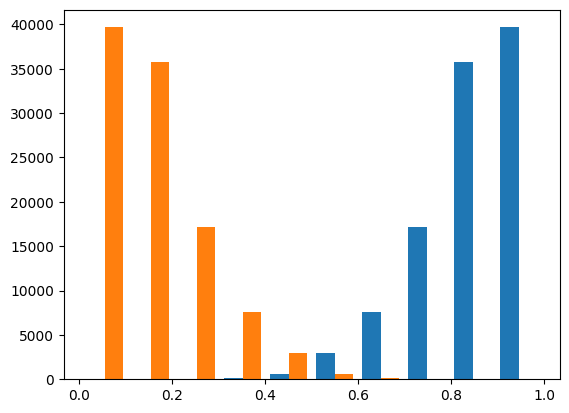

In [54]:
plt.hist(temp)

In [57]:
validate(X_test, y_test, estimators)

{'F1-weighted Score': 0.10384959713518352,
 'F1-micro Score': 0.9614714740721496,
 'ROC-AUC Score': 0.528652850872598,
 'Precision': 0.30486202365308807,
 'Recall': 0.062584299973024}

# NN Embeddings

In [14]:
def preproc2(df, cols_drop):
    cols_drop = [i for i in cols_drop if i not in ['sample_ml_new', 'feature756']]
    df = df.drop(cols_drop, axis=1)
    X_train, X_test, y_train, y_test = train_test_split(
    df.drop('target', axis=1),
    df['target'],
    test_size=0.2,
    random_state=42,
        shuffle=True,
        stratify=df['target']
    )

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test

In [15]:
X_train1, X_test1, y_train1, y_test1 = preproc2(pd.concat([X, df['target']], axis=1),
                                                cols_with_one_unique_num)

## simple_nn

In [16]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from tqdm import tqdm

In [22]:
class BinaryClassificationDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [23]:
def make_weights_for_balanced_classes(y):
    n_classes = torch.unique(y).size(0)
    count = [0] * n_classes
    for label in y:
        count[label] += 1
    weight_per_class = [0.] * n_classes
    N = float(sum(count))
    for i in range(n_classes):
        weight_per_class[i] = N / float(count[i])
    weight = [0] * len(y)
    for idx, label in enumerate(y):
        weight[idx] = weight_per_class[label]
    return torch.DoubleTensor(weight)

In [24]:
train_dataset = BinaryClassificationDataset(X_train1, y_train1)
test_dataset = BinaryClassificationDataset(X_test1, y_test1)

In [18]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train1), y=np.array(df['target']))

In [25]:
weights = make_weights_for_balanced_classes(torch.tensor(train_dataset.y))
sampler = WeightedRandomSampler(weights, len(weights))

<ipython-input-25-e8c87d99df34>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights = make_weights_for_balanced_classes(torch.tensor(train_dataset.y))


In [ ]:
train_lodetach_ader = DataLoader(train_dataset, batch_size=64, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
class SimpleNN(nn.Module):
    def __init__(self, in_size=46, hid_size=512, out_size=2):
        super().__init__()
        self.in_size = in_size
        self.hid_size = hid_size
        self.out_size = out_size
        self.fc1 = nn.Linear(in_size, hid_size)
        self.bn1 = nn.BatchNorm1d(hid_size)
        self.fc2 = nn.Linear(hid_size, hid_size//2)
        self.bn2 = nn.BatchNorm1d(hid_size//2)
        self.fc3 = nn.Linear(hid_size//2, hid_size//4)
        self.bn3 = nn.BatchNorm1d(hid_size//4)
        self.clf = nn.Linear(hid_size//4, out_size)
        self.relu = nn.LeakyReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, inp):
        out = self.relu(self.bn1(self.fc1(inp)))
#         out = self.dropout(out)
        out = self.relu(self.bn2(self.fc2(out)))
        embs = self.relu(self.bn3(self.fc3(out)))
        clf_out = self.clf(embs)
        return clf_out, embs

In [ ]:
simple_nn = SimpleNN(in_size=42).to('cuda')
optimizer = torch.optim.AdamW(simple_nn.parameters())
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32)).to('cuda')
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

epochs = 20 # 16 лучшее вроде бы

In [ ]:
history = {
    'train_loss': [],
    'val_accuracy': [],
    'val_f1_weighted': [],
    'val_f1_micro': [],
    'val_precision_weighted': [],
    'val_recall_weighted': [],
    'val_roc_auc': []
}

for epoch in tqdm(range(epochs)):
        simple_nn.train()
        running_loss = 0.0

        for batch in train_loader:
            inputs, labels = batch[0].to('cuda'), batch[1].to('cuda')

            optimizer.zero_grad()
            outputs, _ = simple_nn(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            loss.backward()
            optimizer.step()
        scheduler.step()
        avg_loss = running_loss / len(train_loader)
        history['train_loss'].append(avg_loss)

        true_labels = []
        predictions = []
        preds_for_roc_auc = []

        simple_nn.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for batch in test_loader:
                inputs, labels = batch[0].to('cuda'), batch[1].to('cuda')
                outputs, _ = simple_nn(inputs)
                predicted = torch.argmax(outputs, dim=1)
                true_labels.extend(labels.cpu().numpy())
                predictions.extend(predicted.cpu().numpy())

                probabilities = F.softmax(outputs, dim=1).cpu().numpy()
                preds_for_roc_auc.extend(probabilities[:, 1])

        val_accuracy = (np.array(predictions) == np.array(true_labels)).mean()
        val_f1_weighted = f1_score(true_labels, predictions, average='weighted')
        val_f1_micro = f1_score(true_labels, predictions, average='micro')
        val_precision_weighted = precision_score(true_labels, predictions, average='weighted')
        val_recall_weighted = recall_score(true_labels, predictions, average='weighted')
        val_roc_auc = roc_auc_score(true_labels, preds_for_roc_auc)

        history['train_loss'].append(avg_loss)
        history['val_accuracy'].append(val_accuracy)
        history['val_f1_weighted'].append(val_f1_weighted)
        history['val_f1_micro'].append(val_f1_micro)
        history['val_precision_weighted'].append(val_precision_weighted)
        history['val_recall_weighted'].append(val_recall_weighted)
        history['val_roc_auc'].append(val_roc_auc)

        print(f'Epoch [{epoch+1}/{epochs}]. Loss: {avg_loss:.4f}',
              f'Val Accuracy: {val_accuracy:.4f}',
              f'Val F1-Weighted: {val_f1_weighted:.4f}',
              f'Val Precision Weighted: {val_precision_weighted:.4f}',
              f'Val Recall Weighted: {val_recall_weighted:.4f}',
              f'Val RocAuc: {val_roc_auc:.4f}')

  5%|▌         | 1/20 [00:22<07:06, 22.46s/it]

Epoch [1/20]. Loss: 0.1436 Val Accuracy: 0.0452 Val F1-Weighted: 0.0215 Val Precision Weighted: 0.9570 Val Recall Weighted: 0.0452 Val RocAuc: 0.7014


 10%|█         | 2/20 [00:45<06:46, 22.60s/it]

Epoch [2/20]. Loss: 0.1240 Val Accuracy: 0.2120 Val F1-Weighted: 0.3038 Val Precision Weighted: 0.9527 Val Recall Weighted: 0.2120 Val RocAuc: 0.6753


 15%|█▌        | 3/20 [01:07<06:23, 22.53s/it]

Epoch [3/20]. Loss: 0.1012 Val Accuracy: 0.3496 Val F1-Weighted: 0.4809 Val Precision Weighted: 0.9492 Val Recall Weighted: 0.3496 Val RocAuc: 0.6641


 20%|██        | 4/20 [01:30<06:00, 22.53s/it]

Epoch [4/20]. Loss: 0.0856 Val Accuracy: 0.4154 Val F1-Weighted: 0.5528 Val Precision Weighted: 0.9471 Val Recall Weighted: 0.4154 Val RocAuc: 0.6557


 25%|██▌       | 5/20 [01:52<05:37, 22.52s/it]

Epoch [5/20]. Loss: 0.0746 Val Accuracy: 0.5266 Val F1-Weighted: 0.6587 Val Precision Weighted: 0.9455 Val Recall Weighted: 0.5266 Val RocAuc: 0.6524


 30%|███       | 6/20 [02:15<05:16, 22.59s/it]

Epoch [6/20]. Loss: 0.0670 Val Accuracy: 0.5330 Val F1-Weighted: 0.6643 Val Precision Weighted: 0.9447 Val Recall Weighted: 0.5330 Val RocAuc: 0.6449


 35%|███▌      | 7/20 [02:38<04:54, 22.64s/it]

Epoch [7/20]. Loss: 0.0616 Val Accuracy: 0.6090 Val F1-Weighted: 0.7271 Val Precision Weighted: 0.9441 Val Recall Weighted: 0.6090 Val RocAuc: 0.6497


 40%|████      | 8/20 [03:00<04:30, 22.52s/it]

Epoch [8/20]. Loss: 0.0561 Val Accuracy: 0.6058 Val F1-Weighted: 0.7246 Val Precision Weighted: 0.9439 Val Recall Weighted: 0.6058 Val RocAuc: 0.6499


 45%|████▌     | 9/20 [03:22<04:07, 22.50s/it]

Epoch [9/20]. Loss: 0.0516 Val Accuracy: 0.6421 Val F1-Weighted: 0.7524 Val Precision Weighted: 0.9434 Val Recall Weighted: 0.6421 Val RocAuc: 0.6480


 50%|█████     | 10/20 [03:45<03:45, 22.54s/it]

Epoch [10/20]. Loss: 0.0479 Val Accuracy: 0.6574 Val F1-Weighted: 0.7638 Val Precision Weighted: 0.9428 Val Recall Weighted: 0.6574 Val RocAuc: 0.6468


 55%|█████▌    | 11/20 [04:07<03:22, 22.51s/it]

Epoch [11/20]. Loss: 0.0451 Val Accuracy: 0.6731 Val F1-Weighted: 0.7752 Val Precision Weighted: 0.9421 Val Recall Weighted: 0.6731 Val RocAuc: 0.6410


 60%|██████    | 12/20 [04:30<03:00, 22.56s/it]

Epoch [12/20]. Loss: 0.0418 Val Accuracy: 0.7179 Val F1-Weighted: 0.8066 Val Precision Weighted: 0.9418 Val Recall Weighted: 0.7179 Val RocAuc: 0.6462


 65%|██████▌   | 13/20 [04:53<02:37, 22.56s/it]

Epoch [13/20]. Loss: 0.0392 Val Accuracy: 0.7303 Val F1-Weighted: 0.8150 Val Precision Weighted: 0.9412 Val Recall Weighted: 0.7303 Val RocAuc: 0.6433


 70%|███████   | 14/20 [05:15<02:15, 22.59s/it]

Epoch [14/20]. Loss: 0.0371 Val Accuracy: 0.7192 Val F1-Weighted: 0.8075 Val Precision Weighted: 0.9406 Val Recall Weighted: 0.7192 Val RocAuc: 0.6364


 75%|███████▌  | 15/20 [05:38<01:52, 22.56s/it]

Epoch [15/20]. Loss: 0.0353 Val Accuracy: 0.7365 Val F1-Weighted: 0.8191 Val Precision Weighted: 0.9407 Val Recall Weighted: 0.7365 Val RocAuc: 0.6411


 80%|████████  | 16/20 [06:00<01:30, 22.57s/it]

Epoch [16/20]. Loss: 0.0325 Val Accuracy: 0.7419 Val F1-Weighted: 0.8227 Val Precision Weighted: 0.9404 Val Recall Weighted: 0.7419 Val RocAuc: 0.6386


 85%|████████▌ | 17/20 [06:23<01:07, 22.57s/it]

Epoch [17/20]. Loss: 0.0312 Val Accuracy: 0.7580 Val F1-Weighted: 0.8332 Val Precision Weighted: 0.9403 Val Recall Weighted: 0.7580 Val RocAuc: 0.6392


 90%|█████████ | 18/20 [06:46<00:45, 22.59s/it]

Epoch [18/20]. Loss: 0.0294 Val Accuracy: 0.7757 Val F1-Weighted: 0.8445 Val Precision Weighted: 0.9398 Val Recall Weighted: 0.7757 Val RocAuc: 0.6380


 95%|█████████▌| 19/20 [07:08<00:22, 22.61s/it]

Epoch [19/20]. Loss: 0.0284 Val Accuracy: 0.7722 Val F1-Weighted: 0.8423 Val Precision Weighted: 0.9402 Val Recall Weighted: 0.7722 Val RocAuc: 0.6377


100%|██████████| 20/20 [07:31<00:00, 22.58s/it]

Epoch [20/20]. Loss: 0.0275 Val Accuracy: 0.8048 Val F1-Weighted: 0.8626 Val Precision Weighted: 0.9393 Val Recall Weighted: 0.8048 Val RocAuc: 0.6382


# Autoencoder

In [26]:
class TabDataset(Dataset):
    def __init__(self, X, y=None, train_mode=True):
        self.x = X
        self.y = y
        self.train_mode = train_mode


    def __getitem__(self, idx):
        if self.train_mode:
            return torch.tensor(self.x[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.int32)
        else:
            return torch.tensor(self.x[idx], dtype=torch.float32)

    def __len__(self):
        return len(self.x)

In [27]:
train_dataset = TabDataset(X_train1, y_train1.values)
val_dataset = TabDataset(X_test1, y_test1.values)
train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [28]:
class AutoencoderSkipConnection(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(AutoencoderSkipConnection, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, hidden_size),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, input_size),
        )

        # Skip connections
        self.skip_connections = nn.ModuleList()
        for i in range(len(self.encoder) // 2):  # Добавляем skip connections для половины слоев кодировщика
            self.skip_connections.append(nn.Linear(hidden_size, hidden_size))

        # Xavier (Glorot) initialization
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_normal_(module.weight)

    def forward(self, x):
        encoded = x
        skip_connections = []

        # Encoder
        for layer in self.encoder:
            encoded = layer(encoded)
            if isinstance(layer, nn.Linear):
                skip_connections.append(encoded)

        # Decoder
        for i, layer in enumerate(self.decoder):
            if isinstance(layer, nn.Linear):
#                 encoded = encoded + skip_connections[2 - i // 3]
                encoded = layer(encoded)

        return encoded

обучение автоенкодера и поиск аномалий


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from tqdm import tqdm_notebook


device = torch.device("cuda")
model = AutoencoderSkipConnection(70, 16).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
num_epochs = 20

#wandb.init(project="purple-hack")

for epoch in tqdm(range(num_epochs)):
    model.train()
    total_train_loss = 0.0
    train_batches = 0

    for batch_idx, data in enumerate(train_loader):
        x, _ = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, x)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        train_batches += 1

    average_train_loss = total_train_loss / train_batches
    print(f'Train Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_train_loss:.4f}')

    #wandb.log({"Train Loss": average_train_loss}, step=epoch)

    model.eval()
    total_val_loss = 0.0
    val_batches = 0

    for batch_idx, data in enumerate(val_loader):
        x, _ = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, x)
        loss.backward()
        optimizer.step()

        total_val_loss += loss.item()
        val_batches += 1

    average_val_loss = total_val_loss / val_batches
    print(f'Val Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_val_loss:.4f}')

    #wandb.log({"Val Loss": average_val_loss}, step=epoch)
    print('-' * 20)

In [36]:
X_train = np.array([])
y_train = np.array([])
X_test = np.array([])
y_test = np.array([])
for el in tqdm_notebook(train_loader):
    data, y = el
    data = data.to(device)
    X_train = np.append(X_train, model(data).detach().cpu().numpy())
    y_train = np.append(y_train, y.numpy())
for el in tqdm_notebook(val_loader):
    data, y = el
    data = data.to(device)
    X_test = np.append(X_test, model(data).detach().cpu().numpy())
    y_test = np.append(y_test, y.numpy())

<ipython-input-36-818b36a40db1>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for el in tqdm_notebook(train_loader):


  0%|          | 0/6496 [00:00<?, ?it/s]

<ipython-input-36-818b36a40db1>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for el in tqdm_notebook(val_loader):


  0%|          | 0/1624 [00:00<?, ?it/s]

In [39]:
X_train_new = X_train.reshape(len(train_dataset), -1)
X_test_new = X_test.reshape(len(val_dataset), -1)

In [42]:
# Восстанавливаем данные
# reconstructed_data = model(data_tensor).detach().numpy()

# Сравниваем исходные данные с восстановленными
reconstruction_error = np.mean(np.abs(X_train1 - X_train_new), axis=1)

# Устанавливаем порог для обнаружения аномалий
threshold = np.percentile(reconstruction_error, 90) # 95-й процентиль

# Находим индексы аномалий
anomaly_indices = np.where(reconstruction_error > threshold)[0]

print(f"Аномалии обнаружены на индексах: {anomaly_indices}")

Аномалии обнаружены на индексах: [     1     31     35 ... 415683 415684 415686]


In [43]:
X_train1 = X_train1[~np.isin(np.arange(len(X_train1)), anomaly_indices)]
y_train1 = y_train1[~np.isin(np.arange(len(y_train1)), anomaly_indices)]
